# **Read In Pollution Dataset**
The dataset we will be using comes from air quality sensors across South Korea. The sensors measure and record all types of air pollutants/particles in the air, but for this we will only look at PM2.5 (fine dust).

In [82]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [83]:
#Reads in Pollution csv
pollution = pd.read_csv("../input/south-korean-pollution/south-korean-pollution-data.csv",
                       parse_dates=['date'],
                       index_col='date')
#Filters for only pm25 values in Jeongnim-Dong City, sorted by date
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
#starts the dataset at 2018 and ends in 2022(due to breaks in data in previous years)
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution[start:end]
print('SAMPLE OF TIME SERIES DATA:')
pollution.head()

SAMPLE OF TIME SERIES DATA:


date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64

# **Impute Missing Dates**
Time series data is especially sensitive to missing values. For this reason, we need to impute any missing time steps. In this dataset there are a handful of missing time steps which we will impute the value of the previous time step.

In [84]:
#Checks for and imputes missing dates
a = pd.date_range(start="2018-01-01", end="2022-01-01", freq="D") #continous dates
b = pollution.index #our time series
diff_dates = a.difference(b) # finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d") #1 day
for date in diff_dates:
    prev_val = pollution[date-td] #takes the previous value
    pollution[date] = prev_val #imputes previous value

pollution.sort_index(inplace=True)
#sets the time index frequency as daily
pollution.freq = "D"

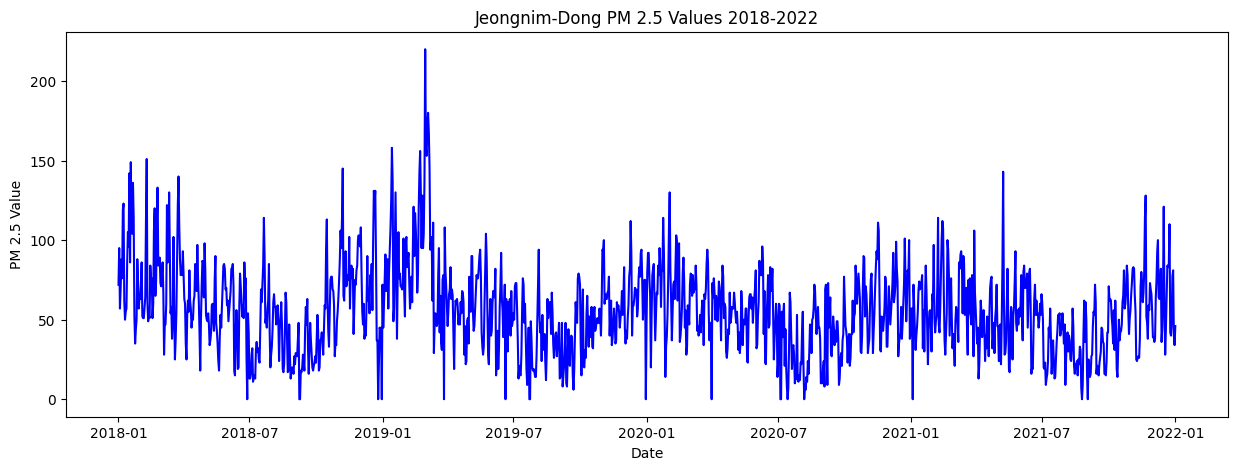

In [85]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong PM 2.5 Values 2018-2022')
plt.show()

# **Split Dataset Into Train/Test**
You may have done a train/test split before using random subsets of the entire dataset. In time series forecasting problems, the test data needs to be a block of the most recent time steps. This is in order to prevent data lookahead in our model (meaning the model would already know the future).

In [86]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2020-12-31')
train = pollution[:end_train_ix] # Jan 2018-2021
test = pollution[end_train_ix:] # Jan 2021-2022

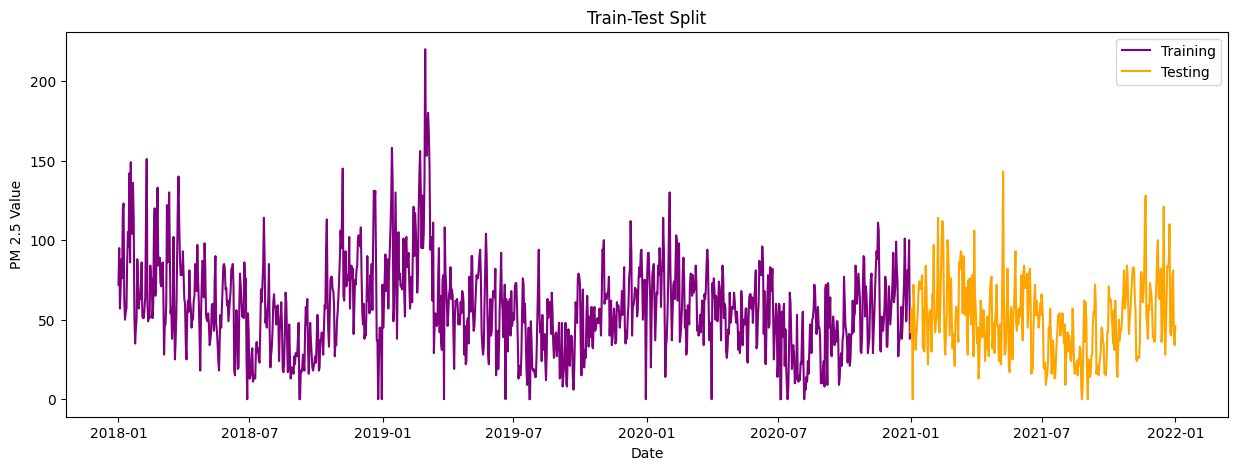

In [87]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

# **Process Dataset with Windows**
Time series data needs to be sliced into windows before being sent to a ML model. A window is essentially a limited range snapshot of our time series data. Say we have an array of values:

[1, 2, 3, 4, 5, 6, 7, 8, 9]

If we have a window size of 4 and we want to forecast 1 timestep in advance, this would be the result:

[1, 2, 3, 4] [5]

[2, 3, 4, 5] [6]

[3, 4, 5, 6] [7]

[4, 5, 6, 7] [8]

[5, 6, 7, 8] [9]

In [88]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

The train_data will now have batches of windowed time series data. The batches are filled with arrays of 14 pm25 values and their target values.

# **Custom Callback**
Callbacks are used in Tensorflow to allow user intervention during model training. A callback can be executed at a number of specific intances during model training. For example:

* on_batch_begin/end
* on_epoch_begin/end
* on_predict_batch_begin/end
* on_predict_begin/end
* on_test_batch_begin/end
* on_test_begin/end
* on_train_batch_begin/end
* on_train_begin/end
We will create CustomCallback which will stop the model from training once the model reaches under 10 mean absolute error on the training set.

In [89]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

# **Predefined Callback**

-LearningRateScheduler

There are also a number of predefined callbacks. We will use the LearningRateScheduler to dynamically update the learning rate of our optimizer. This predefined callback takes a funtion that updates the learning rate as an argument.

In [90]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# **LSTM Model**
LSTM (Long Short-Term Memory) layers are sequence aware and can carry meaning from previous time steps. These layers are very commonly used in all machine learning tasks where order is important -- to include time series forecasting.

**Pros:**

* Can retain information from far in the past to make its prediction
* Proven to be highly effective

**Cons:**
* Many parameters
* Long training time

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_7 (Lambda)               │ (None, 14, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 14, 256)        │       133,120 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,409 (2.26 MB)

 Trainable params: 593,409 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

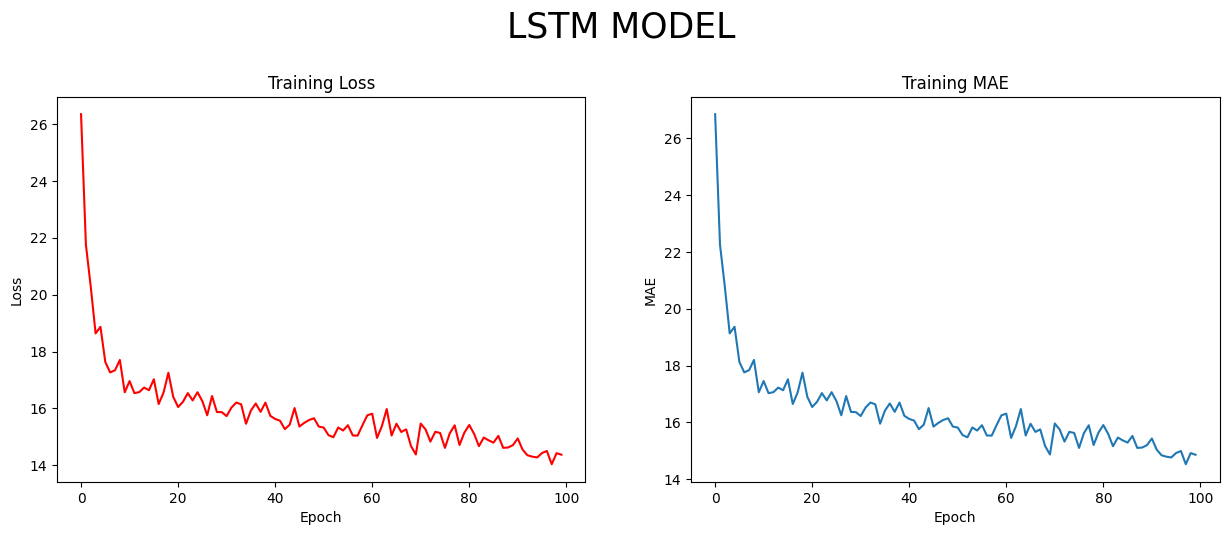

					FINAL LOSS: 14.38 | FINAL MAE: 14.87


In [93]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

# **Convolution Model**
2D Convolution layers are commonly used in computer vision tasks. Their 1D version may be used for time series data. The 1D convolutional layer tries to find patterns in different segments of the time series data.

**Pros:**

* Low parameters
* Fast training time

**Cons:**

* Tends to put more weight on recent values

In [94]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1, 
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_8 (Lambda)               │ (None, 14, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 14, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 14, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,129 (156.75 KB)

 Trainable params: 40,129 (156.75 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

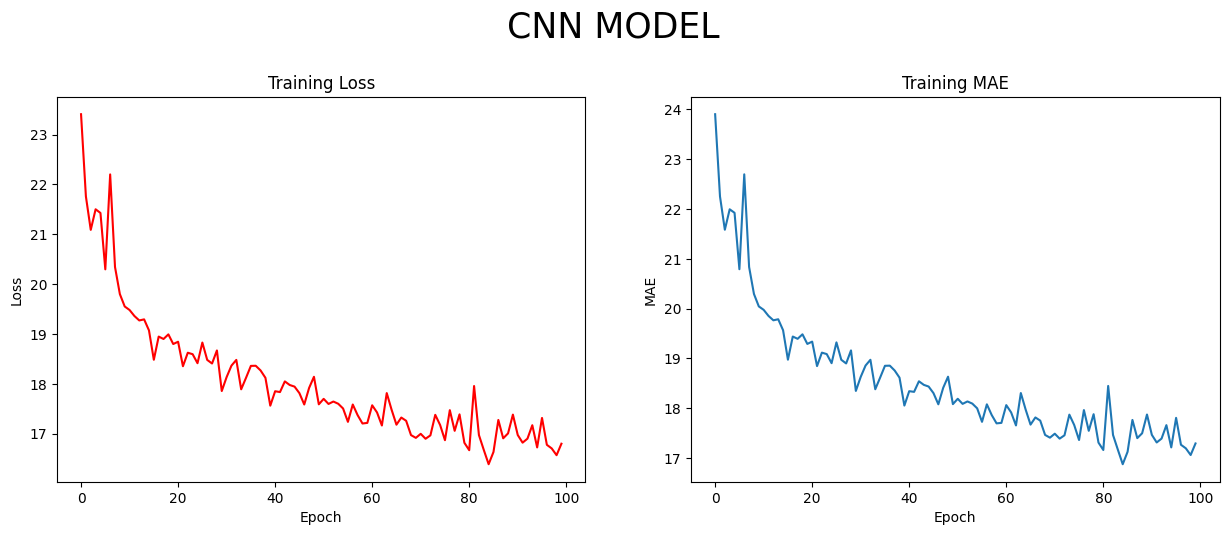

					FINAL LOSS: 16.8 | FINAL MAE: 17.29


In [96]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

# **Mixed Architecture Model**
If we are trying to get the best of both worlds, we can mix the Convolution layers with the LSTM layers.

In [97]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_9 (Lambda)               │ (None, 14, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 14, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,225 (2.76 MB)

 Trainable params: 724,225 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

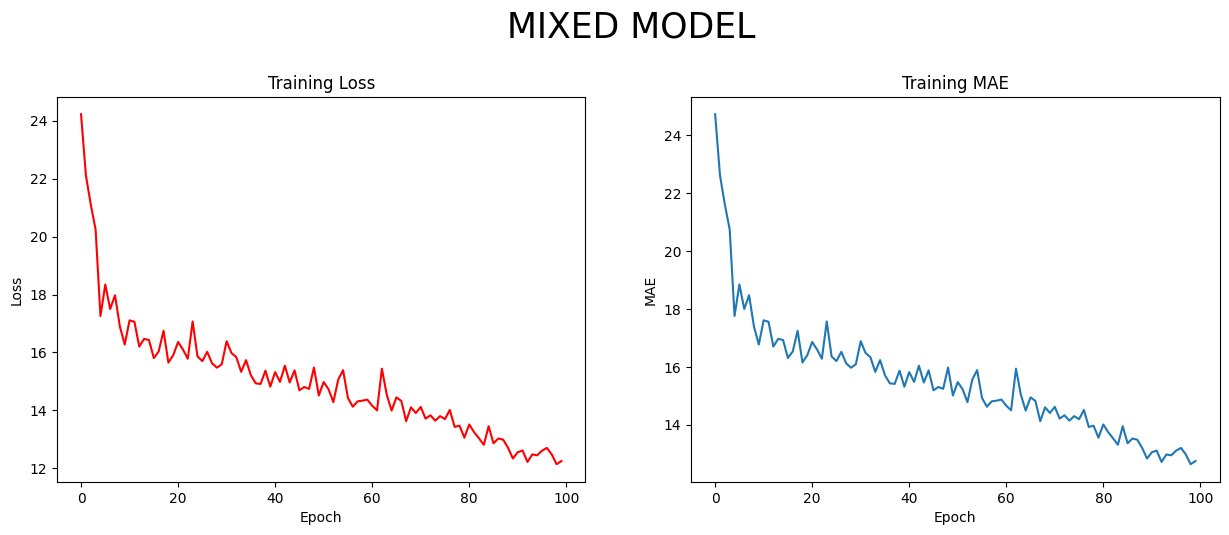

					FINAL LOSS: 12.26 | FINAL MAE: 12.75


In [99]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

# **Evaluate Models on Test Set**
Unlike other machine learning tasks, we cannot directly predict and evaluate the model's performance from the test data. First, we must create windows (similar to how we did on the training data) on the last 14 days of the training set and the test set. These length-14 windows will each correspond with a timestep of the test data. Predicting the next value for each of these windows will be our forecast.

*Note: Current state of the art machine learning models achieve around 13 MAE score for this problem*

In [125]:
# Get forecasts from models

all_models = [
    ('LSTM MODEL', lstm_model),
    ('CNN MODEL', cnn_model),
    ('MIXED MODEL', mixed_model)
]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

forecast_data = pd.concat([train[-WINDOW:], test[:-1]]).values

for name, model in all_models:
    # Convert values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data)
    
    # Create windowed slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    
    # Flatten windowed data by batching
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW + 1))
    
    # Create batches of windows
    test_data = test_data.batch(32).prefetch(1)
    
    # Get model predictions
    preds = model.predict(test_data)
    
    # Append predictions to the forecast dictionary
    model_forecasts[name].append(preds)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [126]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 14.52
CNN MAE: 17.8
MIXED MAE: 14.88


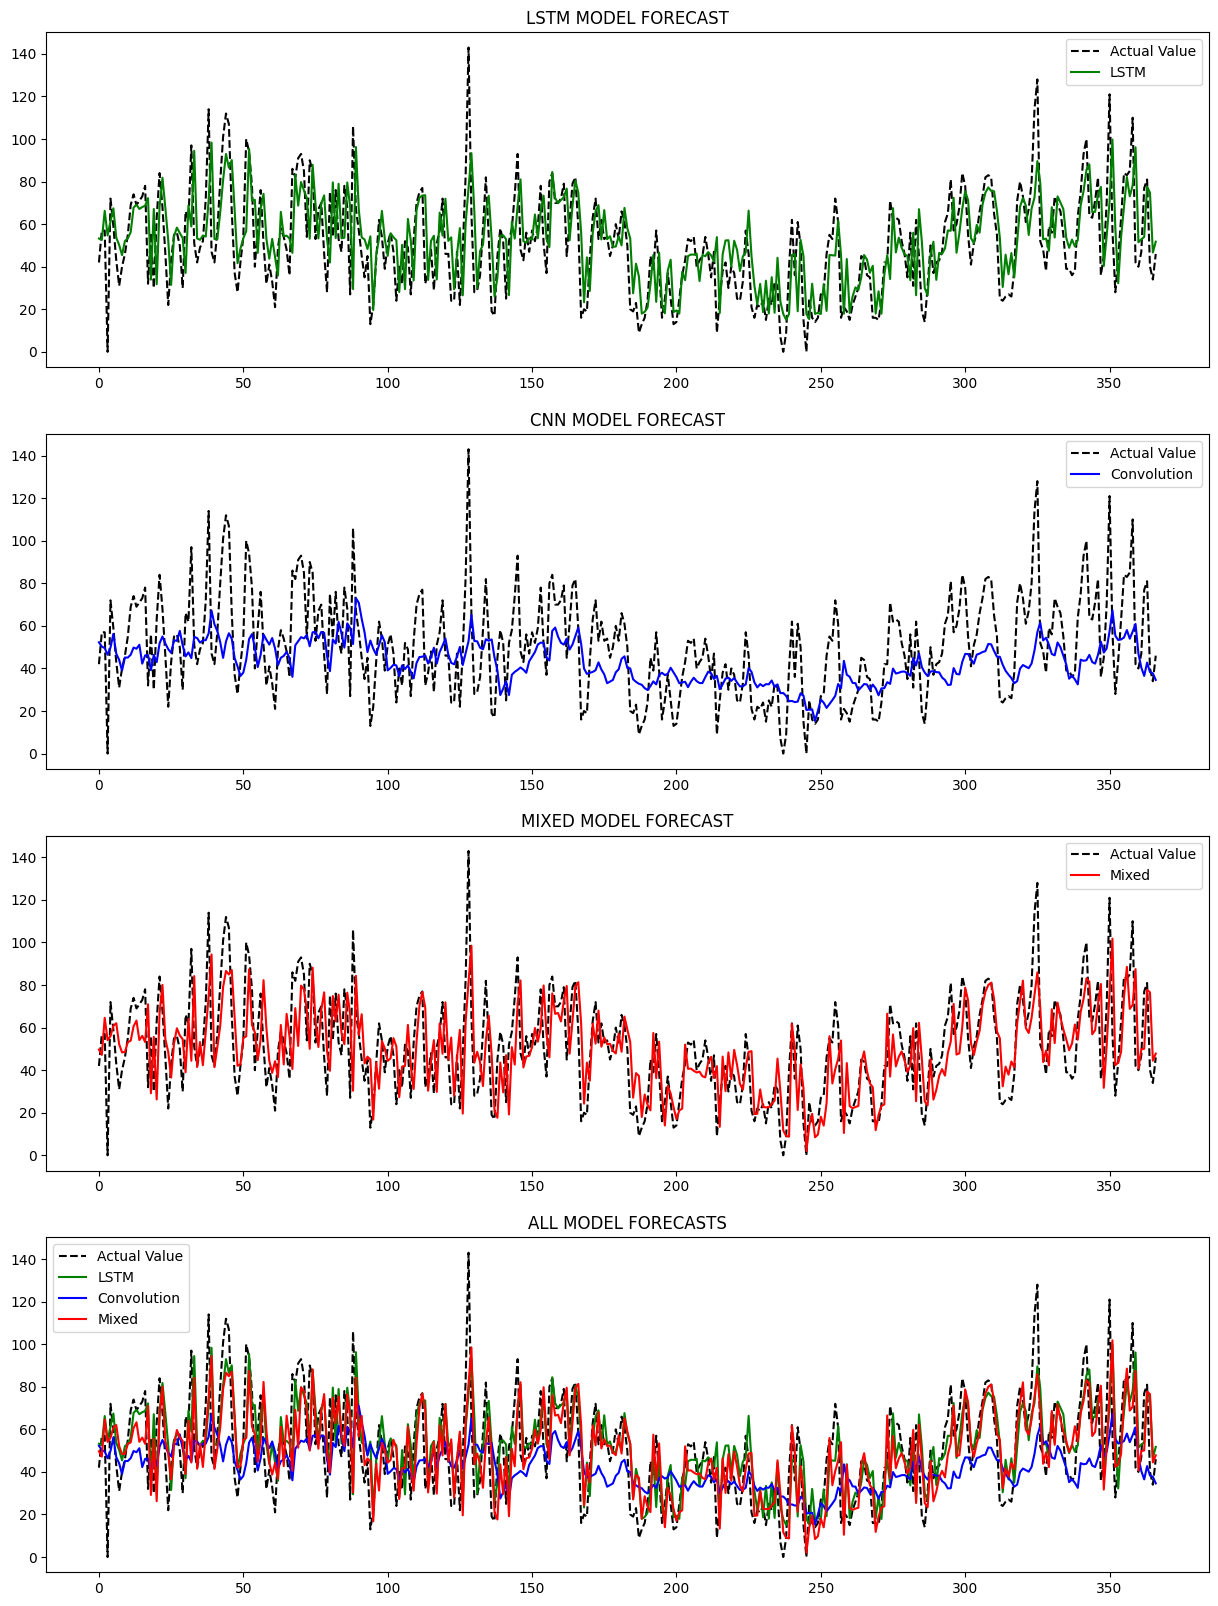

In [ ]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()